In [6]:
import requests
import base64
import os
import io
from io import BytesIO

def upload_image(imagebase64str: str) -> str:
    image = base64.b64decode(imagebase64str)

    # Convert to a bytes-like object for the requests library
    image_file = BytesIO(image)
    image_file.name = 'image.jpg'  # You can specify the filename here
    image_file.seek(0)  # Move to the start of the file

    files = {'file': (image_file.name, image_file, 'image/jpeg'), 'json': (None, '{"user_id": "tracking_images"}', 'application/json')}
    response = requests.post(f"http://127.0.0.1:8002/images/", files=files)
    if response.status_code == 200:
        return response.json()['id']
    else:
        raise Exception(f"Error uploading image: {response.status_code}, {response.text}")

def detect_activity_inside_video(video_id) -> dict:
    response = requests.post(f"http://127.0.0.1:16004/video-inference-with-id/{video_id}")
    if response.status_code == 200:
        json_file = response.json()
        json_file['type'] = 'ecole-video-activity'
        json_file['data'] = f"The video depicts the activity of '{json_file['pred']}'"
        json_file['merged_image'] = upload_image(json_file['merged_image'])
        json_file["blended_imgs"] = [upload_image(img) for img in json_file["blended_imgs"]]
        del json_file['query_prompt']
        return json_file
    else:
        raise Exception(f"Error fetching video: {response.status_code}, {response.text}")

{'sims': {'climbing': 0.054145101457834244,
  'crawling': 0.06642667204141617,
  'grasping': 0.1718650907278061,
  'hiding': 0.059875186532735825,
  'jumping': 0.03317941725254059,
  'picking up': 0.10517232865095139,
  'pulling': 0.12029741704463959,
  'pushing': 0.1307961791753769,
  'putting down': 0.07038100808858871,
  'rolling': 0.0651003047823906,
  'running': 0.03911188989877701,
  'sliding': 0.0306817889213562,
  'walking': 0.052967630326747894},
 'pred': 'grasping',
 'merged_image': {'id': '65d155da10459e8829fcd8b9',
  'url': '',
  'content_type': 'image/jpeg',
  'file_name': 'image.jpg'},
 'blended_imgs': [{'id': '65d155da10459e8829fcd8ba',
   'url': '',
   'content_type': 'image/jpeg',
   'file_name': 'image.jpg'},
  {'id': '65d155db10459e8829fcd8bb',
   'url': '',
   'content_type': 'image/jpeg',
   'file_name': 'image.jpg'},
  {'id': '65d155db10459e8829fcd8bc',
   'url': '',
   'content_type': 'image/jpeg',
   'file_name': 'image.jpg'},
  {'id': '65d155db10459e8829fcd8bd'
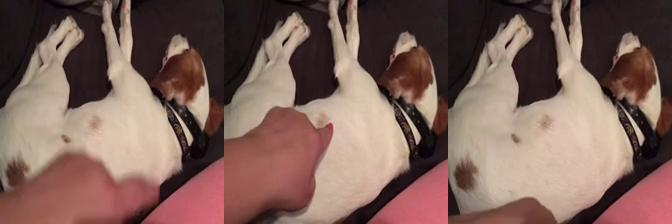
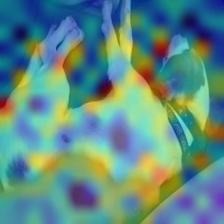
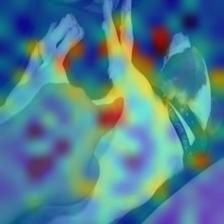
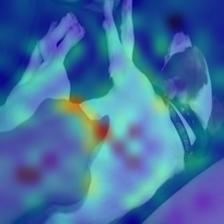
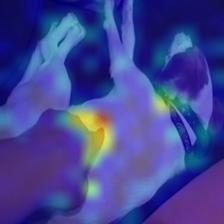
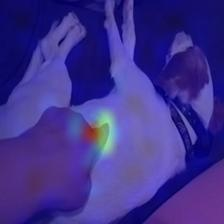
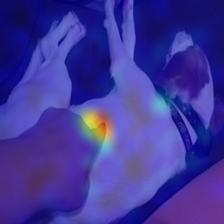
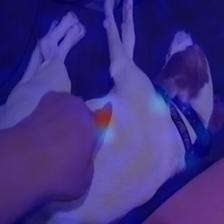
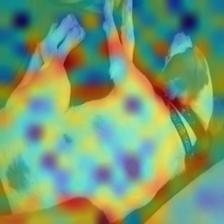

In [7]:
detect_activity_inside_video("65c5f6aaf09b5ac909575a60")

In [7]:
%pip install requests pillow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


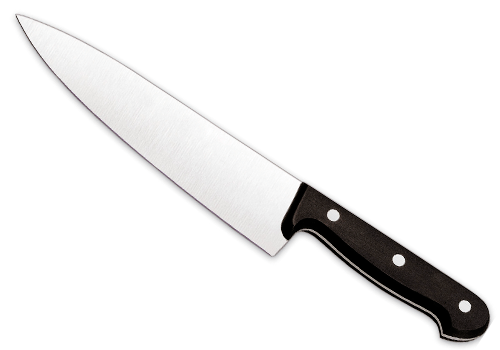

In [12]:
import requests
from PIL import Image
import io

response = requests.get(
    "https://images.immediate.co.uk/production/volatile/sites/30/2020/08/knife-head_0-e1436fc.png?resize=768,574"
)
image = response.content
pil_image = Image.open(io.BytesIO(image))
pil_image

In [21]:
from typing import List
import requests
import numpy as np

def match_and_rank(
    list_name: List[str], list_score: List[float]
) -> List[dict[str, str]]:
    list_obj = [
        {"name": name, "value": score} for name, score in zip(list_name, list_score)
    ]
    list_obj.sort(key=lambda x: x["value"], reverse=True)
    return list_obj

def match_and_rank_list(
    list_name: List[str], list_list_score: List[List[float]]
) -> List[dict[str, str]]:
    ret_list = []
    for list_score in list_list_score:
        if len(list_score) != len(list_name):
            raise ValueError("The length of the list of names and the list of scores must be the same")
        list_obj = [
            {"name": name, "value": score} for name, score in zip(list_name, list_score)
        ]
        list_obj.sort(key=lambda x: x["value"], reverse=True)
        ret_list.append(list_obj)
    return ret_list

def upload_object_detection_info(image_id: str, json_file: dict) -> str:
    response = requests.post(
        "http://blender09.cs.illinois.edu:8002/object_detection-json", json=json_file, params={"image_id": image_id}
    )
    if response.status_code == 200:
        return response
    else:
        raise Exception(f"Error uploading object detection info: {response.status_code}, {response.text}")

def explain_concept(image_id:str) -> dict:
    response = requests.get(f"http://localhost:8002/object_detection-json/{image_id}")

    if response.status_code != 200:
        return {"type": "ecole-message", "error": f"Error fetching image: {response.status_code}, {response.text}"}
    else: 
        return {
            "type": "ecole-json-reason",
            "image_id": image_id,
            "url": f"ecole-json-reason/{image_id}",
            "interpretation": f"The results of the object detection for image {image_id} are as follows: {response.json()['total_score']}",
        }


def what_is_it(image_id: str) -> dict:
    response = requests.get(f"http://localhost:8002/images/{image_id}")
    if response.status_code != 200:
        return {"type": "ecole-message", "error": f"Error fetching image: {response.status_code}, {response.text}"}
    files = {"image": ("image.jpg", response.content, "image/jpeg")}
    payload = {"user_id": "new_user", "threshold": "0.1"}

    response_2 = requests.post(
        f"http://localhost:16005/predict-concept", files=files, data=payload
    ) 

    
            if response_2.status_code == 200:
                ret_json = response_2.json()
                new_json = {"predicted_label": ret_json["predicted_label"] }
                new_json["segmentations"] = ret_json["prediction"]["segmentations"]
                new_json["concepts_prediction"] = match_and_rank(
                    ret_json["prediction"]["concept_names"],
                    ret_json["prediction"]["predictors_scores"],
                )
                new_json["trained_attr_img_scores"] = match_and_rank(
                    ret_json["prediction"]["trained_attributes"],
                    ret_json["prediction"]["predicted_concept_outputs"][
                        "trained_attr_img_scores"
                    ],
                )
                zx_attributes = [item["name"] for item in ret_json["concept_attributes"]]
                new_json["zs_attr_img_scores"] = match_and_rank(
                    zx_attributes,
                    ret_json["prediction"]["predicted_concept_outputs"]["zs_attr_img_scores"],
                )
                new_json["trained_attr_region_scores"] = match_and_rank_list(
                    ret_json["prediction"]["trained_attributes"],
                    ret_json["prediction"]["predicted_concept_outputs"][
                        "trained_attr_region_scores"
                    ],
                )
                new_json["zs_attr_region_scores"] = match_and_rank_list(
                    zx_attributes,
                    ret_json["prediction"]["predicted_concept_outputs"][
                        "zs_attr_region_scores"
                    ],
                )
                new_json["region_scores"] = ret_json["prediction"]["predicted_concept_outputs"][
                    "region_scores"
                ]
                new_json["predicted_top_k"] = match_and_rank(ret_json["predicted_top_k"]['names'], ret_json["predicted_top_k"]['values'])

                new_json["total_score"] = [
                    {
                        "name": "Cummulative Score",
                        "value": ret_json["prediction"]["predicted_concept_outputs"][
                            "cum_score"
                        ],
                    },
                    {
                        "name": "Image Features",
                        "value": ret_json["prediction"]["predicted_concept_outputs"][
                            "img_score"
                        ],
                    },
                    {
                        "name": "Region Features",
                        "value": ret_json["prediction"]["predicted_concept_outputs"][
                            "region_score"
                        ],
                    },
                    {
                        "name": "Trained Attributes: Image",
                        "value": np.mean(
                            ret_json["prediction"]["predicted_concept_outputs"][
                                "trained_attr_img_scores"
                            ]
                        ),
                    },
                    {
                        "name": "Trained Attributes: Region",
                        "value": np.mean(
                            ret_json["prediction"]["predicted_concept_outputs"][
                                "trained_attr_region_scores"
                            ]
                        ),
                    },
                    {
                        "name": "Zero-shot Attributes: Image",
                        "value": np.mean(
                            ret_json["prediction"]["predicted_concept_outputs"][
                                "zs_attr_region_scores"
                            ]
                        ),
                    },
                    {
                        "name": "Zero-shot Attributes: Region",
                        "value": np.mean(
                            ret_json["prediction"]["predicted_concept_outputs"][
                                "zs_attr_img_scores"
                            ]
                        ),
                    },
                ]

                res = upload_object_detection_info(image_id, new_json)

                if res.status_code != 200:
                    raise Exception(f"Error uploading object detection info: {res.status_code}, {res.text}")

                give_json = {
                    "type": "ecole-message",
                    "image_id": image_id,
                    "interpretation": "I don't know what this is" if ret_json["predicted_label"] == 'unknown' else f"This is a {ret_json['predicted_label']}",
                    "predicted_label": ret_json["predicted_label"],
                    "predicted_top_k": new_json["predicted_top_k"],
                }

                return give_json
            else:
                raise Exception(f"Error fetching image: {response_2.status_code}, {response_2.text}")

In [2]:
pil_image = Image.open(
    "/Users/khanhduynguyen/Desktop/ECOLE-Project/mint-chat-ui/chat-ui/testimages/fork/0002.jpg"
)
pil_image

NameError: name 'Image' is not defined

In [24]:
obj = what_is_it("65d7e09af973b1a91e2c5355")

In [25]:
obj

{'type': 'ecole-message',
 'image_id': '65d7e09af973b1a91e2c5355',
 'interpretation': 'This is a hoe',
 'predicted_label': 'hoe',
 'predicted_top_k': [{'name': 'hoe', 'value': 0.8574277758598328},
  {'name': 'spoon', 'value': 0.09745597094297409},
  {'name': 'knife', 'value': 0.0022964670788496733},
  {'name': 'bowl', 'value': 0.0019092134898528457},
  {'name': 'mug', 'value': 0.0009075267589651048}]}

In [26]:
explain_concept("65d7e09af973b1a91e2c5355")

{'type': 'ecole-json-reason',
 'image_id': '65d7e09af973b1a91e2c5355',
 'url': 'ecole-json-reason/65d7e09af973b1a91e2c5355',
 'interpretation': "The results of the object detection for image 65d7e09af973b1a91e2c5355 are as follows: [{'name': 'Cummulative score', 'value': 1.794088363647461}, {'name': 'Image Features', 'value': 0.5089554786682129}, {'name': 'Region Features', 'value': -0.9287335872650146}, {'name': 'Trained Attributes: Image', 'value': 0.030910244614288613}, {'name': 'Trained Attributes: Region', 'value': -0.0659086781780462}, {'name': 'Zero-shot Attributes: Image', 'value': 0.6640255153179169}, {'name': 'Zero-shot Attributes: Region', 'value': 0.5055772631118695}]"}

In [140]:
obj.keys()

dict_keys(['segmentations', 'concepts_prediction', 'trained_attrs_img_prediction', 'za_img_region_prediction', 'trained_attrs_region_prediction', 'za_attrs_region_prediction', 'region_scores'])

In [86]:
obj['prediction'].keys()

dict_keys(['concept_names', 'segmentations', 'zs_attrs', 'predictors_scores', 'predicted_index', 'predicted_label', 'true_index', 'true_concept_outputs', 'predicted_concept_outputs', 'trained_attributes'])

In [87]:
concepts_prediction = match_and_rank(
    obj["prediction"]["concept_names"], obj["prediction"]["predictors_scores"]
)
concepts_prediction

[{'name': 'hoe', 'value': -0.8438504338264465},
 {'name': 'spoon', 'value': -1.8631560802459717},
 {'name': 'fork', 'value': -2.1026771068573},
 {'name': 'mug', 'value': -5.308194160461426},
 {'name': 'shovel', 'value': -8.532454490661621},
 {'name': 'knife', 'value': -8.664451599121094},
 {'name': 'bowl', 'value': -9.09425163269043}]

In [88]:
obj["prediction"]['predicted_concept_outputs']

{'img_score': 1.7922704219818115,
 'region_scores': [-0.09713499993085861,
  -0.11640739440917969,
  -0.011529380455613136,
  -0.15696783363819122,
  -0.3219526410102844],
 'region_score': -0.7039922475814819,
 'trained_attr_img_scores': [-0.24533958733081818,
  -0.361581414937973,
  0.037225354462862015,
  0.48472073674201965,
  -0.2783591151237488,
  -0.9196722507476807,
  0.5726331472396851,
  -0.16358523070812225,
  -0.5633343458175659,
  0.29159340262413025,
  -0.07050876319408417,
  -0.5694204568862915,
  0.6615289449691772,
  0.08460026979446411,
  0.2526509463787079,
  0.05796424672007561,
  0.20589882135391235,
  -0.2823861539363861,
  0.3716694414615631,
  0.5279873609542847,
  0.9923521876335144,
  -0.2577919363975525,
  -0.1521175056695938,
  0.38944998383522034,
  0.2535117566585541,
  -1.0059844255447388,
  -0.8857774138450623,
  0.9144595861434937,
  -0.16292530298233032,
  -0.3325040340423584,
  0.3678019046783447,
  0.11307301372289658,
  0.26608791947364807,
  0.35813

In [94]:
trained_attrs_region_prediction = match_and_rank_list(
    obj["prediction"]["trained_attributes"],
    obj["prediction"]["predicted_concept_outputs"]["trained_attr_region_scores"],
)
trained_attrs_region_prediction

[[{'name': 'hardwood', 'value': 0.2132418155670166},
  {'name': 'oval shaped', 'value': 0.19009719789028168},
  {'name': 'rectangular', 'value': 0.17493198812007904},
  {'name': 'glass', 'value': 0.16663525998592377},
  {'name': 'metal', 'value': 0.15748974680900574},
  {'name': 'brown', 'value': 0.15563516318798065},
  {'name': 'pointy', 'value': 0.1503559648990631},
  {'name': 'stainless steel', 'value': 0.11943476647138596},
  {'name': 'cubed', 'value': 0.09705263376235962},
  {'name': 'gray', 'value': 0.08761753141880035},
  {'name': 'steel', 'value': 0.08435950428247452},
  {'name': 'purple', 'value': 0.07707053422927856},
  {'name': 'circular', 'value': 0.06826800853013992},
  {'name': 'cylindrical', 'value': 0.058387499302625656},
  {'name': 'yellow', 'value': 0.05610039830207825},
  {'name': 'concrete', 'value': 0.018839331343770027},
  {'name': 'wooden', 'value': 0.01853388547897339},
  {'name': 'aluminum', 'value': 0.0028800726868212223},
  {'name': 'red', 'value': -0.0001143

In [96]:
trained_attrs_img_prediction = match_and_rank(
    obj["prediction"]["trained_attributes"],
    obj["prediction"]["predicted_concept_outputs"]["trained_attr_img_scores"],
)
trained_attrs_img_prediction

[{'name': 'rectangular', 'value': 0.9923521876335144},
 {'name': 'cardboard', 'value': 0.9144595861434937},
 {'name': 'circular', 'value': 0.6615289449691772},
 {'name': 'pink', 'value': 0.5726331472396851},
 {'name': 'pointy', 'value': 0.5279873609542847},
 {'name': 'gray', 'value': 0.48472073674201965},
 {'name': 'wooden', 'value': 0.39840030670166016},
 {'name': 'triangular', 'value': 0.38944998383522034},
 {'name': 'oval shaped', 'value': 0.3716694414615631},
 {'name': 'glass', 'value': 0.3678019046783447},
 {'name': 'metal', 'value': 0.3581386208534241},
 {'name': 'white', 'value': 0.29159340262413025},
 {'name': 'hardwood', 'value': 0.26608791947364807},
 {'name': 'aluminum', 'value': 0.2535117566585541},
 {'name': 'cubed', 'value': 0.2526509463787079},
 {'name': 'cylindrical', 'value': 0.20589882135391235},
 {'name': 'granite', 'value': 0.11307301372289658},
 {'name': 'concical', 'value': 0.08460026979446411},
 {'name': 'curved', 'value': 0.05796424672007561},
 {'name': 'brown',

In [93]:
len(trained_attrs_region_prediction)

5

In [99]:
zx_attributes = [item['name'] for item in obj["concept_attributes"]]

In [100]:
za_attrs_region_prediction = match_and_rank_list(
    zx_attributes,
    obj["prediction"]["predicted_concept_outputs"]["zs_attr_region_scores"],
)
za_attrs_region_prediction

[[{'name': 'metal blade', 'value': 0.10132908821105957},
  {'name': 'soil or dirt on blade', 'value': 0.02982761338353157},
  {'name': 'wooden handle', 'value': -0.17107295989990234}],
 [{'name': 'metal blade', 'value': 0.10422926396131516},
  {'name': 'soil or dirt on blade', 'value': 0.031828951090574265},
  {'name': 'wooden handle', 'value': -0.16707323491573334}],
 [{'name': 'metal blade', 'value': 0.06780524551868439},
  {'name': 'soil or dirt on blade', 'value': 0.011083811521530151},
  {'name': 'wooden handle', 'value': -0.1873842030763626}],
 [{'name': 'metal blade', 'value': 0.22584453225135803},
  {'name': 'soil or dirt on blade', 'value': 0.1083582192659378},
  {'name': 'wooden handle', 'value': -0.049752190709114075}],
 [{'name': 'metal blade', 'value': 0.07732231914997101},
  {'name': 'soil or dirt on blade', 'value': 0.016135210171341896},
  {'name': 'wooden handle', 'value': -0.1845920830965042}]]

In [101]:
za_img_region_prediction = match_and_rank(
    zx_attributes,
    obj["prediction"]["predicted_concept_outputs"]["zs_attr_img_scores"],
)
za_img_region_prediction

[{'name': 'metal blade', 'value': 0.36239928007125854},
 {'name': 'soil or dirt on blade', 'value': 0.0947297066450119},
 {'name': 'wooden handle', 'value': -0.7071563601493835}]

In [104]:
obj["prediction"]["segmentations"]

{'localized_bbox': [99, 27, 126, 207],
 'part_masks': {'shape': [5, 225, 225],
  'dtype': 'torch.bool',
  'data': 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [109]:
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.0 MB 10.7 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [114]:
import numpy as np
import base64
def encoded_tensor_to_tensor(encoded_tensor: dict[str, str]) -> Image:
    # Map the stored dtype string back to a NumPy dtype
    dtype_map = {
        "torch.float32": np.float32,
        "torch.int32": np.int32,
        "torch.bool": bool,
        # Add more mappings as needed for different tensor dtypes
    }

    numpy_dtype = dtype_map[encoded_tensor['dtype']]  # Convert the dtype string to a NumPy dtype

    # Decode the base64 string back to bytes
    decoded_bytes = base64.b64decode(encoded_tensor["data"])

    # Convert bytes back to a numpy array with the original dtype
    numpy_array = np.frombuffer(decoded_bytes, dtype=numpy_dtype).reshape(
        encoded_tensor["shape"]
    )
    return numpy_array

In [129]:
t = encoded_tensor_to_tensor(obj["prediction"]["segmentations"]["part_masks"])
masks = [find_contours(mask) for mask in t]

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'findContours'
> Overload resolution failed:
>  - image data type = bool is not supported
>  - Expected Ptr<cv::UMat> for argument 'image'
